# Part1 import 및 준비

- python version 3.8.17

- torch version = 1.13.0

In [ ]:
# ##### Clone OneFormer Repo
# %cd /home/eunwoo/experiment/PSSC/Oneformer(instance)/content
# !rm -rf OneFormer/
# !git clone https://github.com/SHI-Labs/OneFormer-Colab.git
# ! mv OneFormer-Colab OneFormer
# %cd /home/eunwoo/experiment/PSSC/Oneformer(instance)/content/OneFormer/

In [ ]:
# # # Install opencv (required for running the demo)
# !pip3 install -U opencv-python --quiet
# !pip3 install natten -f https://shi-labs.com/natten/wheels/cu113/torch1.10.1/index.html --quiet

# # # Install other dependencies
# !pip3 install git+https://github.com/cocodataset/panopticapi.git --quiet
# !pip3 install git+https://github.com/mcordts/cityscapesScripts.git --quiet

# ## 나는 pip install gradio 로 따로 해야 오류 안뜸
# !pip3 install -r requirements.txt --quiet
# !pip3 install ipython-autotime --quiet
# !pip3 install imutils --quiet

In [ ]:
# import sys, os, distutils.core
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} --quiet
# sys.path.insert(0, os.path.abspath('./detectron2'))

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # 디른 GPU 번호 쓰니까 결과가 좀 달라짐 ;;


import torch, gc
gc.collect()
torch.cuda.empty_cache()

print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

%cd /home/eunwoo/experiment/PSSC/Oneformer(instance)/content/OneFormer/
import sys, os, distutils.core
dist = distutils.core.run_setup("./detectron2/setup.py")
sys.path.insert(0, os.path.abspath('./detectron2'))


True
1.13.0
1
NVIDIA A100-SXM4-40GB MIG 3g.20gb
/home/eunwoo/experiment/PSSC/Oneformer(instance)/content/OneFormer


In [2]:
###### Import Libraries and other Utilities

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="oneformer")

# Import libraries
import numpy as np
import cv2
import torch
# from google.colab.patches import cv2_imshow
import imutils

# Import detectron2 utilities
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data import MetadataCatalog
from demo.defaults import DefaultPredictor
from demo.visualizer import Visualizer, ColorMode

# import OneFormer Project
from oneformer import (
    add_oneformer_config,
    add_common_config,
    add_swin_config,
    add_dinat_config,
    add_convnext_config,
)


###### 4. Define helper functions

cpu_device = torch.device("cpu")###############
gpu_device = torch.device("cuda")
SWIN_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_swin_large_IN21k_384_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_swin_large_IN21k_384_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_swin_large_IN21k_384_bs16_160k.yaml",}

DINAT_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_dinat_large_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_dinat_large_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_dinat_large_IN21k_384_bs16_160k.yaml",}

def setup_cfg(dataset, model_path, use_swin):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_common_config(cfg)
    add_swin_config(cfg)
    add_dinat_config(cfg)
    add_convnext_config(cfg)
    add_oneformer_config(cfg)
    if use_swin:
        cfg_path = SWIN_CFG_DICT[dataset]
    else:
        cfg_path = DINAT_CFG_DICT[dataset]
    cfg.merge_from_file(cfg_path)
    cfg.MODEL.DEVICE = 'cuda'###############
    cfg.MODEL.WEIGHTS = model_path
    cfg.freeze()
    return cfg

def setup_modules(dataset, model_path, use_swin):
    cfg = setup_cfg(dataset, model_path, use_swin)
    predictor = DefaultPredictor(cfg)
    metadata = MetadataCatalog.get(
        cfg.DATASETS.TEST_PANOPTIC[0] if len(cfg.DATASETS.TEST_PANOPTIC) else "__unused"
    )
    if 'cityscapes_fine_sem_seg_val' in cfg.DATASETS.TEST_PANOPTIC[0]:
        from cityscapesscripts.helpers.labels import labels
        stuff_colors = [k.color for k in labels if k.trainId != 255]
        metadata = metadata.set(stuff_colors=stuff_colors)
    
    return predictor, metadata

matplotlib data path: /home/eunwoo/anaconda3/envs/pyg/lib/python3.8/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/eunwoo/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/home/eunwoo/.cache/matplotlib
Using fontManager instance from /home/eunwoo/.cache/matplotlib/fontlist-v330.json
Popen(['git', 'version'], cwd=/home/eunwoo/experiment/PSSC/Oneformer(instance)/content/OneFormer, universal_newlines=False, shell=None, istream=None)
Popen(['git', 'version'], cwd=/home/eunwoo/experiment/PSSC/Oneformer(instance)/content/OneFormer, universal_newlines=False, shell=None, istream=None)
Trying paths: ['/home/eunwoo/.docker/config.json', '/home/eunwoo/.dockercfg']
No config file found
[Tracing] Create new propagation context: {'trace_id': '9d7eb6a152834800a3fa1cbd5b0c309d', 'span_id': 'a790f55aacf6c0cf', 'parent_span_id': None, 'dynamic_sampling_context': None}


In [3]:
## call oneformer_pretrained model from Ade20k-data with dinit or swin
use_swin0 = False
predictor_ade_din, metadata_ade_din = setup_modules("ade20k", "250_16_dinat_l_oneformer_ade20k_160k.pth", use_swin0)

use_swin1 = True
predictor_ade_swin, metadata_ade_swin = setup_modules("ade20k", "250_16_swin_l_oneformer_ade20k_160k.pth", use_swin1)

Loading config configs/ade20k/oneformer_dinat_large_IN21k_384_bs16_160k.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
Loading config configs/ade20k/Base-ADE20K-UnifiedSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[10/03 20:05:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from 250_16_dinat_l_oneformer_ade20k_160k.pth ...
[Checkpointer] Loading from 250_16_dinat_l_oneformer_ade20k_160k.pth ...


The checkpoint state_dict contains keys that are not used by the model:
  text_encoder.positional_embedding
  text_encoder.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.0.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.1.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.2.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.2.

[10/03 20:05:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from 250_16_swin_l_oneformer_ade20k_160k.pth ...
[Checkpointer] Loading from 250_16_swin_l_oneformer_ade20k_160k.pth ...


The checkpoint state_dict contains keys that are not used by the model:
  text_encoder.positional_embedding
  text_encoder.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.0.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.1.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.2.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.2.

In [4]:
## call oneformer_pretrained model from Coco-data with dinit or swin

use_swin0 = False
predictor_co_din, metadata_co_din = setup_modules("coco", "150_16_dinat_l_oneformer_coco_100ep.pth", use_swin0)

use_swin1 = True
predictor_co_swin, metadata_co_swin = setup_modules("coco", "150_16_swin_l_oneformer_coco_100ep.pth", use_swin1)

[10/03 20:05:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from 150_16_dinat_l_oneformer_coco_100ep.pth ...
[Checkpointer] Loading from 150_16_dinat_l_oneformer_coco_100ep.pth ...


The checkpoint state_dict contains keys that are not used by the model:
  text_encoder.positional_embedding
  text_encoder.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.0.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.1.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.2.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.2.

[10/03 20:05:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from 150_16_swin_l_oneformer_coco_100ep.pth ...
[Checkpointer] Loading from 150_16_swin_l_oneformer_coco_100ep.pth ...


The checkpoint state_dict contains keys that are not used by the model:
  text_encoder.positional_embedding
  text_encoder.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.0.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.1.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.2.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.2.

In [5]:
def run_pa_pa(img, predictor):
    predictions=predictor(img, "panoptic")["panoptic_seg"]
    return predictions[0]

def run_se_pa(img, predictor):
    predictions=predictor(img, "semantic")["panoptic_seg"]
    return predictions[0]


# Part 2 . train_source backgroud detect하기

In [6]:
# 클래스 전수조사용 파일 만들기
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from tqdm import tqdm



def make_rect_mask(shape,rect_percent=0.2):
    height, width =shape
    rect_mask = np.zeros((height, width), dtype=bool)

    x_center_row, y_center_row = int(height * 0.5), int(width * 0.5)
    x_width_row,y_width_row = int(height*0.15), int(width*(0.5-rect_percent))
    rect_mask[x_center_row-x_width_row:x_center_row+x_width_row,y_center_row-y_width_row:y_center_row+y_width_row] = True

    x_center_col, y_center_col = int(height * 0.45), int(width * 0.5)
    x_width_col,y_width_col = int(height*(0.5-rect_percent)), int(width*0.15)
    rect_mask[x_center_col-x_width_col:x_center_col+x_width_col,y_center_col-y_width_col:y_center_col+y_width_col] = True

    return rect_mask

def find_most_frequent_element(area):
    unique_elements, counts = np.unique(area, return_counts=True)
    most_frequent_element = unique_elements[np.argmax(counts)]
    return most_frequent_element

def check_component(pt_x,pt_y,x_length,y_length,predict_mask, rect_mask=None):    
    
    area = predict_mask[pt_x:pt_x+x_length,pt_y:pt_y+y_length]
    most_frequent_element = find_most_frequent_element(area)

    # predict_mask 0과 1로 이루어진 이진 이미지로 변환
    binary_image = np.where(np.array(predict_mask) == most_frequent_element, 1, 0).astype(np.uint8)
    binary_image = cv2.erode(binary_image, None,iterations = 20) # 처음에는 감소하면서 노이즈를 없애고
    binary_image = cv2.dilate(binary_image, None,iterations = 20) # 부피를 유지시키기위해 팽창
    
    num_labels, labels_im = cv2.connectedComponents(binary_image)

    # Area dominant label 찾기
    unique_elements, counts = np.unique(labels_im[pt_x:pt_x+x_length,pt_y:pt_y+y_length], return_counts=True)
    label_at_area= unique_elements[np.argmax(counts)]

    # rect_mask랑 닿이면 버림. (방어적 stance)
    selected_mask = (labels_im == label_at_area)
    if rect_mask is not None and np.any(selected_mask & rect_mask):
        selected_mask[:] = False

    return selected_mask


def adjust_roi(image, roi, alpha, beta):
    x1, y1, x2, y2 = roi
    roi_image = image[y1:y2, x1:x2].copy()
    adjusted_roi = cv2.convertScaleAbs(roi_image, alpha=alpha, beta=beta)
    image[y1:y2, x1:x2] = adjusted_roi
    return image


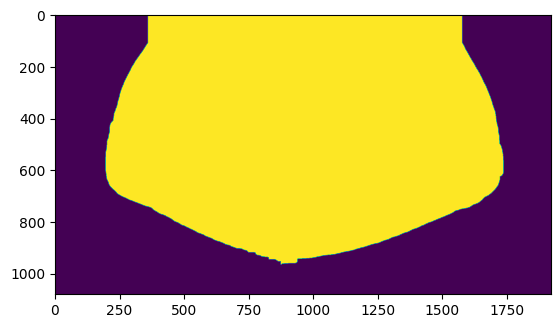

In [50]:
################ train data를 이용해 abandon_mask 만들기 ###############
## ade_din 모델로 abandon_mask 만들기 , ind=1 사용
import cv2
import numpy as np

import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('detectron2').setLevel(logging.ERROR) # 경고 문구 끄는 것.

ind=1
name= 'TRAIN_TARGET_' + str(ind).zfill(4) + '.png'
test_img_path=os.path.join('../../../data/train_target_image',name)
img = cv2.imread(test_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width = img.shape[:2]



# 각 ROI에 대해 contrast와 brightness 조절
###########
alpha_value = 1  # contrast 조절값 1
beta_value = -30 # brightness 조절값 # -30
# 왼쪽 영역
left_roi = (0, 0, int(width*0.15), height)
image = adjust_roi(img, left_roi, alpha_value, beta_value)
# 오른쪽 영역
right_roi = (int(width*0.85), 0, width, height)
image = adjust_roi(image, right_roi, alpha_value, beta_value)


###########
alpha_value = 1.5  # contrast 조절값 1.5
beta_value = -80  # brightness 조절값 -80
# 아래쪽 영역
bottom_roi = (int(width*0.15), int(height*0.75), int(width*0.85), height)
image = adjust_roi(image, bottom_roi, alpha_value, beta_value)

predict_mask=run_se_pa(image, predictor_ade_din).cpu()

vertical=int(height*0.05)
horizonal= int(width*0.05)
point_list=[(0,0),(0, width-horizonal),(height-vertical, 0),(height-vertical,  width-horizonal),(height-vertical, int(width*0.25) ),(height-vertical, int(width*0.75))]

rect_mask = make_rect_mask((height, width),rect_percent=0.12)
tmp_selected_mask = np.zeros((height, width), dtype=bool)
for pt in point_list:
    tmp_selected_mask +=check_component(pt[0],pt[1],vertical,horizonal,predict_mask,rect_mask)

base=np.array(tmp_selected_mask).copy()
base=np.logical_not(base).astype(np.uint8)
abandon_mask = cv2.erode(base, None,iterations = 90)

plt.imshow(abandon_mask)


In [8]:
# train_target image backgroud detect 하기.

model_list=['ade_swin_papa','ade_din_papa' , 'co_swin_papa','co_din_papa']
result={}

for ind in tqdm(range(2923)): #train_target image 총 2923 개
    name= 'TRAIN_TARGET_' + str(ind).zfill(4) + '.png'
    test_img_path=os.path.join('../../../data/train_target_image',name)
    img = cv2.imread(test_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    selected_mask = np.zeros((height, width), dtype=bool)

    for val_list in [(1.4,-30,1.1,-80),(2,-30,0.8,-80)]:
        alpha_value0, beta_value0, alpha_value, beta_value = val_list

        height, width, _ = img.shape
        image = img.copy()
        # 왼쪽 영역
        left_roi = (0, 0, int(width*0.15), height)
        image = adjust_roi(image, left_roi, alpha_value0, beta_value0)
        # 오른쪽 영역
        right_roi = (int(width*0.85), 0, width, height)
        image = adjust_roi(image, right_roi, alpha_value0, beta_value0)
        # 아래쪽 영역
        bottom_roi = (int(width*0.15), int(height*0.75), int(width*0.85), height)
        image = adjust_roi(image, bottom_roi, alpha_value, beta_value)

    ####################################################
        
        for model in model_list:
            if model == 'ade_swin_papa':
                predict_mask=run_pa_pa(image, predictor_ade_swin).cpu()
                # print('1')
            elif model == 'ade_din_papa':
                predict_mask=run_pa_pa(image, predictor_ade_din).cpu()
                # print('2')
            elif model == 'co_swin_papa':
                predict_mask=run_pa_pa(image, predictor_co_swin).cpu()
                # print('3')
            elif model == 'co_din_papa':
                predict_mask=run_pa_pa(image, predictor_co_din).cpu()   

            vertical=int(height*0.05)
            horizonal= int(width*0.05)
            point_list=[(0,0),(0, width-horizonal),(height-vertical, 0),(height-vertical,  width-horizonal),(height-vertical, int(width*0.25) ),(height-vertical, int(width*0.75))]
            
            tmp_selected_mask = np.zeros((height, width), dtype=bool)
            for pt in point_list:
                tmp_selected_mask +=check_component(pt[0],pt[1],vertical,horizonal,predict_mask,abandon_mask)
            
            selected_mask+=tmp_selected_mask
    #######################################################
    result[ind] = selected_mask

100%|██████████| 20/20 [06:39<00:00, 19.98s/it]


# Part 3. Last-backgroud mask using total sum 만들기

In [13]:
#train target image통째로 더해보기
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

idx = 0
name = 'TRAIN_TARGET_' + str(idx).zfill(4) + '.png'
path_img =os.path.join('../../../data/train_target_image',name)
img0 = cv2.imread(path_img)
img0 = cv2.cvtColor(img0, cv2.IMREAD_GRAYSCALE)

#sum_img=np.zeros(img0.shape[:2],np.uint8)
sum_img=np.zeros(img0.shape[:2])

for idx in tqdm(range(2923)):
    name = 'TRAIN_TARGET_' + str(idx).zfill(4) + '.png'
    path_img =os.path.join('../../../data/train_target_image',name)
    img = cv2.imread(path_img)
    img = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)
    sum_img+=img
sum_img=sum_img*255/sum_img.max()
sum_img=sum_img.astype(np.uint8)

100%|██████████| 2923/2923 [04:03<00:00, 12.01it/s]


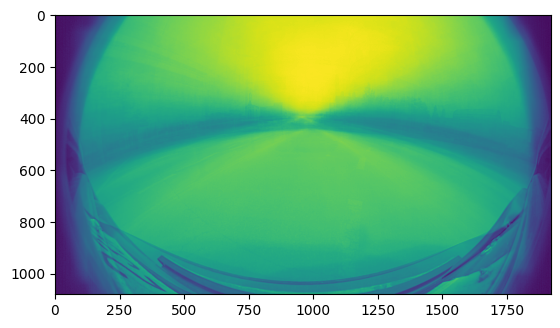

In [14]:
rgb_image = np.stack([sum_img]*3, axis=-1)
plt.imshow(sum_img)

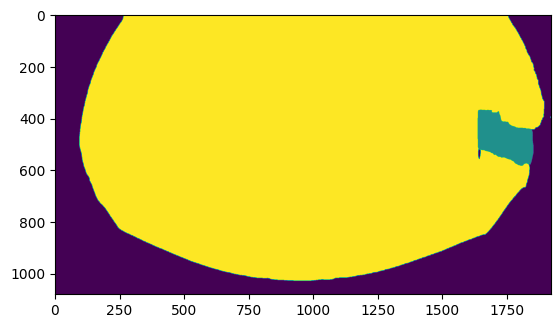

In [15]:

height, width, _ = rgb_image.shape
image = rgb_image.copy()

alpha_value, beta_value = 0.2, +150 # co_din 0.2 +150

# 중앙 영역 색감 조절
roi = (int(width*0.15), 0, int(width*0.85), int(height*0.65))
image = adjust_roi(image, roi, alpha_value, beta_value)

# segmentation 수행
segmentation=run_pa_pa(image, predictor_co_din).cpu()
plt.imshow(segmentation)


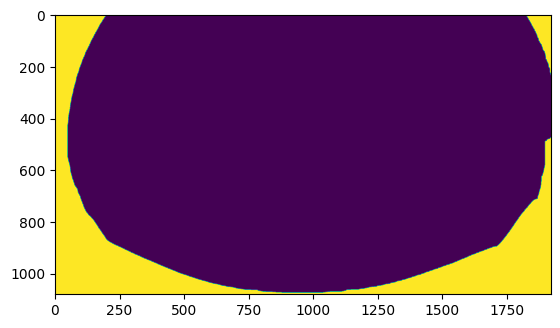

In [36]:
edge_element=int(segmentation[0,0])
binary_image = np.where(np.array(segmentation) == edge_element, 1, 0).astype(np.uint8)

#노이즈 제거
binary_image = cv2.erode(binary_image, None,iterations = 5) 
binary_image = cv2.dilate(binary_image, None,iterations = 10)
binary_image = cv2.erode(binary_image, None,iterations = 5) 

# 방어적 접근
binary_image = cv2.erode(binary_image, None,iterations = 45) 
plt.imshow(binary_image)


# 최종 결과물 (2개)

In [ ]:
## 1. pseudo labeling에 사용한 background (원본: /home/eunwoo/experiment/PSSC/Oneformer(instance)/result/background_dongjin/background_basesum.pickle)
import pickle

background_basesum={}

for k,v in result.items():
    background_basesum[k]= v + binary_image.astype(bool)

# save
with open('../outputs/background_basesum.pickle', 'wb') as f:
    pickle.dump(background_basesum, f, pickle.HIGHEST_PROTOCOL)

In [37]:
### 2. 최후의 마스크만 따로 저장 (원본: 다른번호 GPU사용한듯 1픽셀 다름 /home/eunwoo/experiment/PSSC/Oneformer(instance)/result/background7_abandon65/total_sum_bg.pickle)
import pickle

# save
with open('../outputs/total_sum_bg.pickle', 'wb') as f:
    pickle.dump(binary_image, f, pickle.HIGHEST_PROTOCOL)